In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 4.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import zipfile
from hmmlearn import hmm
import joblib
import matplotlib.pyplot as plt
import cupy as cp
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Define zip file paths for Focal and NonFocal
zip_files_and_paths = [
    {
        "category": "Focal",
        "zip_files": [
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_1_750.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_751_1500.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_1501_2250.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_2251_3000.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_3001_3750.zip"
        ],
        "extract_path": "/content/drive/My Drive/Colab Notebooks/Focal"
    },
    {
        "category": "NonFocal",
        "zip_files": [
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_1_750.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_751_1500.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_1501_2250.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_2251_3000.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_3001_3750.zip"
        ],
        "extract_path": "/content/drive/My Drive/Colab Notebooks/NonFocal"
    }
]

# Loop through each category and process its zip files
for category_info in zip_files_and_paths:
    category = category_info["category"]
    zip_files = category_info["zip_files"]
    extract_path = category_info["extract_path"]

    # Ensure the target extraction directory exists
    os.makedirs(extract_path, exist_ok=True)

    # Process each zip file
    for zip_path in zip_files:
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted {zip_path} to {extract_path}")
        except Exception as e:
            print(f"Failed to extract {zip_path}: {e}")


In [12]:
# Define folder paths and file patterns
folders = {
    "Focal": {
        "folder_path": "/content/drive/My Drive/Colab Notebooks/Focal",
        "file_pattern": "Data_F_Ind"
          # "file_pattern": "Data_F_Ind0001"
    },
    "NonFocal": {
        "folder_path": "/content/drive/My Drive/Colab Notebooks/NonFocal",
        "file_pattern": "Data_N_Ind"
        #  "file_pattern": "Data_N_Ind0001"
    }
}

# Initialize empty dataframes for Focal and NonFocal
focal_data = []
nonfocal_data = []

# Process files and append data to the respective lists
for label, info in folders.items():
    folder_path = info["folder_path"]
    file_pattern = info["file_pattern"]

    for txt_file in sorted(os.listdir(folder_path)):
        if txt_file.startswith(file_pattern) and txt_file.endswith(".txt"):  # Match pattern
            file_path = os.path.join(folder_path, txt_file)

            # Read the file content
            with open(file_path, 'r') as file:
                file_content = file.read()

                # Append to the respective list
                if label == "Focal":
                    focal_data.append({"FileName": txt_file, "Content": file_content})
                elif label == "NonFocal":
                    nonfocal_data.append({"FileName": txt_file, "Content": file_content})

# Convert lists to pandas dataframes
focal_df = pd.DataFrame(focal_data)
nonfocal_df = pd.DataFrame(nonfocal_data)

In [13]:
focal_df

,FileName,Content
0,Data_F_Ind0001.txt,"-23.584467, 22.621477\n -20.180197, 26...."
1,Data_F_Ind0002.txt,"1.770672, 2.166060\n 7.448948, 11...."
2,Data_F_Ind0003.txt,"-22.218569, -6.315594\n -20.903902, 2...."
3,Data_F_Ind0004.txt,"15.340358, -0.708561\n 15.932686, -9...."
4,Data_F_Ind0005.txt,"-139.301895, -32.410355\n -134.347473, -50...."
...,...,...
3745,Data_F_Ind3746.txt,"-119.777565, -4.040848\n -128.405029, -9...."
3746,Data_F_Ind3747.txt,"-40.209297, -25.315691\n -38.833210, -13...."
3747,Data_F_Ind3748.txt,"20.044878, 26.007835\n 24.044386, 23...."
3748,Data_F_Ind3749.txt,"42.665413, 28.149704\n 43.217628, 32...."


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# Function to parse the signal data from the 'Content' column
def parse_signal(content):
    """Parse the signal content, which is a multiline string with comma-separated values."""
    lines = content.strip().split('\n')
    signal = []
    for line in lines:
        # Strip any leading/trailing spaces and split by commas
        line = line.replace(" ", "")  # Remove any extra spaces around the numbers
        signal.append(list(map(float, line.split(','))))  # Convert the string values to float
    return np.array(signal)

# Initialize an array to hold all observed data from all patients
all_observed_data = []

# Loop through the focal_df and nonfocal_df data to load and process each signal
for idx, row in focal_df.iterrows():
    content = row['Content']
    focal_signal = parse_signal(content)
    # Move to GPU
    focal_signal_tensor = torch.tensor(focal_signal, dtype=torch.float32).to(device)
    all_observed_data.append(focal_signal_tensor)

for idx, row in nonfocal_df.iterrows():
    content = row['Content']
    nonfocal_signal = parse_signal(content)
    # Move to GPU
    nonfocal_signal_tensor = torch.tensor(nonfocal_signal, dtype=torch.float32).to(device)
    all_observed_data.append(nonfocal_signal_tensor)

# Combine all the observed data (now on GPU)
combined_data = torch.cat(all_observed_data, dim=0)  # Concatenate the signals on GPU

# Reshape the data to fit the HMM (HMM expects 2D data: samples x features)
combined_data_reshaped = combined_data.reshape(-1, 1)  # Flatten the signals for HMM
observed_data_tensor = torch.tensor(combined_data_reshaped, dtype=torch.float32).to(device)
# Now the combined data is on the GPU

# Define the HMM class
class HMM(torch.nn.Module):
    def __init__(self, n_components, n_features):
        super(HMM, self).__init__()
        self.n_components = n_components
        self.transition_matrix = torch.nn.Parameter(torch.rand(n_components, n_components).to(device))  # Transition matrix
        self.means = torch.nn.Parameter(torch.rand(n_components).to(device))  # Mean of Gaussian for each state
        self.stddevs = torch.nn.Parameter(torch.rand(n_components).to(device))  # Standard deviation of Gaussian for each state
        self.initial_probs = torch.nn.Parameter(torch.rand(n_components).to(device))  # Initial state probabilities
        self.transition_matrix.data = torch.nn.functional.softmax(self.transition_matrix.data, dim=1)
        self.initial_probs.data = torch.nn.functional.softmax(self.initial_probs.data, dim=0)

    def forward(self, observations):
        """ The forward pass for the HMM model. """
        n_samples = observations.size(0)
        log_probabilities = torch.zeros(n_samples, self.n_components, device=device)

        # Calculate emission probabilities for each state (Gaussian distributions)
        for state in range(self.n_components):
            mean = self.means[state]
            stddev = self.stddevs[state]
            # Gaussian likelihood
            log_probabilities[:, state] = -0.5 * torch.log(2 * torch.pi * stddev ** 2) - \
                                          (observations.squeeze() - mean) ** 2 / (2 * stddev ** 2)

        return log_probabilities

# Initialize the model
model = HMM(n_components=3, n_features=1).to(device)  # Ensure the model is on the GPU

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training setup
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass: compute log-likelihood of the observations given the model
    log_probs = model(combined_data_reshaped)  # Now it's using the data on GPU

    # Compute the negative log-likelihood (sum across all samples and states)
    log_likelihood = log_probs.sum()

    # Backpropagate and update parameters
    log_likelihood.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Log-Likelihood: {log_likelihood.item()}")

print("Model training completed.")


<ipython-input-15-92738b3340e3>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observed_data_tensor = torch.tensor(combined_data_reshaped, dtype=torch.float32).to(device)


Epoch 10/100, Log-Likelihood: -15303857668096.0
Epoch 20/100, Log-Likelihood: -18258224742400.0
Epoch 30/100, Log-Likelihood: -22603397857280.0
Epoch 40/100, Log-Likelihood: -29717893742592.0
Epoch 50/100, Log-Likelihood: -43286903390208.0
Epoch 60/100, Log-Likelihood: -76316778954752.0
Epoch 70/100, Log-Likelihood: -203052061556736.0
Epoch 80/100, Log-Likelihood: -1840966596034560.0
Epoch 90/100, Log-Likelihood: -5.959993831666483e+16
Epoch 100/100, Log-Likelihood: -5.960271286553805e+16
Model training completed.


In [9]:
# torch.save(model.state_dict(), 'epilepsy_hmm_model_real_data.pth')

In [16]:
### Decoding Signals with Viterbi Algorithm

# Assume model is trained and device is set to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def viterbi(observations, model):
    """
    Decodes the most likely sequence of hidden states using the Viterbi algorithm.
    The function assumes you are using a PyTorch model.
    """
    n_samples = observations.size(0)
    n_states = model.n_components

    # Initialize Viterbi variables
    log_probs = model(observations)  # Log probability for each state at each time step
    dp = torch.zeros(n_samples, n_states, device=device)
    backpointer = torch.zeros(n_samples, n_states, device=device)

    # Initialization (first time step)
    dp[0] = log_probs[0] + torch.log(model.initial_probs)

    # Recursion (for all subsequent time steps)
    for t in range(1, n_samples):
        for state in range(n_states):
            trans_probs = dp[t-1] + torch.log(model.transition_matrix[:, state])
            dp[t, state] = log_probs[t, state] + torch.max(trans_probs)
            backpointer[t, state] = torch.argmax(trans_probs)

    # Termination: find the most probable last state
    best_last_state = torch.argmax(dp[-1])

    # Backtrack to find the best path
    best_path = torch.zeros(n_samples, dtype=torch.long, device=device)
    best_path[-1] = best_last_state
    for t in range(n_samples - 2, -1, -1):
        best_path[t] = backpointer[t+1, best_path[t+1]]

    return best_path

In [17]:
# Example data (replace with your actual data tensor)
observed_data = observed_data_tensor
# Assuming the trained model is available
hidden_states = viterbi(observed_data, model)
print(f"Most likely hidden states: {hidden_states}")

KeyboardInterrupt: 

In [ ]:
# #Load the model
# model = HMM(n_components, n_features).to(device)
# model.load_state_dict(torch.load('epilepsy_hmm_model_real_data.pth'))
# model.eval()  # Switch to evaluation mode

In [ ]:
# # Test on new data
# predicted_log_probs = model(new_data_tensor)  # Likelihood of the new data
# predicted_states = viterbi(new_data_tensor, model)  # Most likely hidden states

# print(f"Predicted log-likelihood: {predicted_log_probs.sum().item()}")
# print(f"Predicted hidden states: {predicted_states}")

## Analysis

In [3]:
# Define folder paths and file patterns
folders = {
    "Focal": {
        "folder_path": "/content/drive/My Drive/Colab Notebooks/Focal",
        # "file_pattern": "Data_F_Ind"
          "file_pattern": "Data_F_Ind0001"
    },
    "NonFocal": {
        "folder_path": "/content/drive/My Drive/Colab Notebooks/NonFocal",
        # "file_pattern": "Data_N_Ind"
         "file_pattern": "Data_N_Ind0001"
    }
}

# Initialize empty dataframes for Focal and NonFocal
focal_data = []
nonfocal_data = []

# Process files and append data to the respective lists
for label, info in folders.items():
    folder_path = info["folder_path"]
    file_pattern = info["file_pattern"]

    for txt_file in sorted(os.listdir(folder_path)):
        if txt_file.startswith(file_pattern) and txt_file.endswith(".txt"):  # Match pattern
            file_path = os.path.join(folder_path, txt_file)

            # Read the file content
            with open(file_path, 'r') as file:
                file_content = file.read()

                # Append to the respective list
                if label == "Focal":
                    focal_data.append({"FileName": txt_file, "Content": file_content})
                elif label == "NonFocal":
                    nonfocal_data.append({"FileName": txt_file, "Content": file_content})

# Convert lists to pandas dataframes
focal_df = pd.DataFrame(focal_data)
nonfocal_df = pd.DataFrame(nonfocal_data)

In [3]:
def process_coordinates(df):
    """
    Processes the 'Content' column of the dataframe and splits the coordinate pairs
    into 'X' and 'Y' columns.

    Args:
    - df (pd.DataFrame): Input dataframe with 'FileName' and 'Content' columns.

    Returns:
    - pd.DataFrame: DataFrame with only 'X' and 'Y' columns.
    """
    # Step 1: Split the 'Content' column by newline and explode the list into individual rows
    df['Content'] = df['Content'].str.split('\n')
    df_exploded = df.explode('Content')

    # Step 2: Split the coordinate pairs into 'X' and 'Y' columns
    df_exploded[['X', 'Y']] = df_exploded['Content'].str.split(',', expand=True)

    # Step 3: Convert 'X' and 'Y' to numeric (float), errors='coerce' to handle any invalid entries
    df_exploded[['X', 'Y']] = df_exploded[['X', 'Y']].apply(pd.to_numeric, errors='coerce')

    # Drop the 'FileName' and 'Content' columns
    df_exploded.drop(columns=['FileName', 'Content'], inplace=True)

    return df_exploded

# Process focal_df and nonfocal_df to get only X and Y columns
focal_df_cleaned = process_coordinates(focal_df)
nonfocal_df_cleaned = process_coordinates(nonfocal_df)

In [5]:
focal_df_cleaned.dropna(inplace=True)
nonfocal_df_cleaned.dropna(inplace=True)

In [6]:
focal_df_cleaned

,X,Y
0,-23.584467,22.621477
0,-20.180197,26.547081
0,-16.631811,28.431639
0,-12.762078,30.098673
0,-10.451992,30.030939
...,...,...
0,18.566311,0.149878
0,18.048351,-3.365252
0,17.817694,-4.722577
0,17.604982,-3.035015


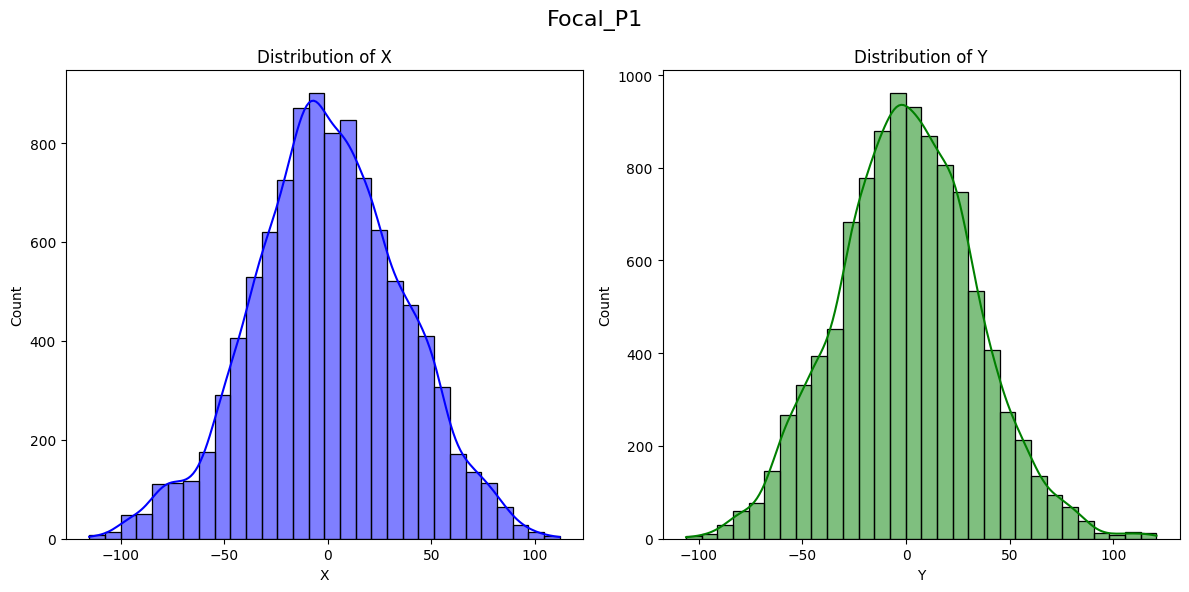

In [11]:
# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot the distribution for the 'X' column
plt.subplot(1, 2, 1)
sns.histplot(focal_df_cleaned['X'], kde=True, color='blue', bins=30)
plt.title('Distribution of X')

# Plot the distribution for the 'Y' column
plt.subplot(1, 2, 2)
sns.histplot(focal_df_cleaned['Y'], kde=True, color='green', bins=30)
plt.title('Distribution of Y')

# Add a general title
plt.suptitle('Focal_P1', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


Neural Network

In [38]:
# Define the LSTM + 1D-CNN hybrid model
class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(HybridModel, self).__init__()

        # 1D Convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Apply convolution layers
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        # Reshape to (batch_size, seq_len, input_size) for LSTM
        x = x.permute(0, 2, 1)

        # Apply LSTM
        lstm_out, (hn, cn) = self.lstm(x)

        # Get the last hidden state from LSTM for classification
        out = self.fc(hn[-1])
        return out

# Set parameters
input_size = 64  # Output from the last convolution layer
hidden_size = 128  # Size of LSTM hidden state
num_classes = 3  # Subclinical seizure, clinical seizure, normal

# Adjusted data generation parameters
patients = 5
channels_per_series = 750
time_points = 10240  # 20 seconds at 512 Hz
sampling_rate = 512  # Hz

# Data loading function to process the data
def process_data(df, time_points):
    all_data = []
    for index, row in df.iterrows():
        # Split the coordinates in the 'Content' column
        coordinates = row['Content'].split('\n')
        patient_data = []

        for coord in coordinates:
            # Clean the string to ensure it contains only valid numerical data
            try:
                # Convert each coordinate pair to a list of floats
                data_point = list(map(float, coord.split(', ')))
                patient_data.append(data_point)
            except ValueError:
                # Handle empty or malformed strings by skipping them
                continue

        # Flatten the data for this patient/channel into one 1D array
        patient_data = np.array(patient_data).flatten()

        # If the data length is less than time_points, pad with zeros
        if len(patient_data) < time_points:
            padding = time_points - len(patient_data)
            patient_data = np.pad(patient_data, (0, padding), mode='constant')

        # If the data length is greater than time_points, truncate it
        elif len(patient_data) > time_points:
            patient_data = patient_data[:time_points]

        all_data.append(patient_data)

    return np.array(all_data)

# Process focal_df and nonfocal_df
focal_data = process_data(focal_df, time_points)
nonfocal_data = process_data(nonfocal_df, time_points)

# Stack data from both sources (focal and nonfocal)
data = np.vstack((focal_data, nonfocal_data))

# Convert the data to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)

# Generate dummy labels (for now, you can adjust them based on your real data)
labels = np.random.randint(0, num_classes, len(data))  # Random labels (0, 1, 2)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Reshape the data to be in the right format for Conv1D
# Conv1D expects the shape [batch_size, channels, length], where:
#   - batch_size = patients * channels_per_series (because each channel is treated as a separate sample)
#   - channels = 1 (each sequence for each channel)
#   - length = time_points (each time series has time_points length)
data_tensor = data_tensor.view(-1, 1, time_points)  # Reshape: [patients * channels_per_series, 1, time_points]

# Create DataLoader for batching
dataset = TensorDataset(data_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Hyperparameter search: Learning rates
learning_rates = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

# Function to train and evaluate with different learning rates
def train_with_lr(lr):
    # Reinitialize the model and optimizer for each learning rate
    model = HybridModel(input_size=64, hidden_size=128, num_classes=num_classes)

    # Move model to device (GPU or CPU)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop for the current learning rate
    for epoch in range(10):  # For 10 epochs
        model.train()
        total_loss = 0
        for batch_data, batch_labels in dataloader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_data)

            # Calculate loss
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Learning Rate: {lr}, Average Loss: {avg_loss:.4f}")

    return avg_loss

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Testing all learning rates
best_loss = float('inf')
best_lr = None

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    avg_loss = train_with_lr(lr)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_lr = lr

print(f"Best learning rate: {best_lr} with loss: {best_loss}")


Training with learning rate: 0.0001
Epoch 1, Learning Rate: 0.0001, Average Loss: 1.0573
Epoch 2, Learning Rate: 0.0001, Average Loss: 1.0337
Epoch 3, Learning Rate: 0.0001, Average Loss: 1.0104
Epoch 4, Learning Rate: 0.0001, Average Loss: 0.9875
Epoch 5, Learning Rate: 0.0001, Average Loss: 0.9649
Epoch 6, Learning Rate: 0.0001, Average Loss: 0.9428
Epoch 7, Learning Rate: 0.0001, Average Loss: 0.9211
Epoch 8, Learning Rate: 0.0001, Average Loss: 0.8999
Epoch 9, Learning Rate: 0.0001, Average Loss: 0.8792
Epoch 10, Learning Rate: 0.0001, Average Loss: 0.8589
Training with learning rate: 1e-05
Epoch 1, Learning Rate: 1e-05, Average Loss: 1.1339
Epoch 2, Learning Rate: 1e-05, Average Loss: 1.1317
Epoch 3, Learning Rate: 1e-05, Average Loss: 1.1294
Epoch 4, Learning Rate: 1e-05, Average Loss: 1.1271
Epoch 5, Learning Rate: 1e-05, Average Loss: 1.1248
Epoch 6, Learning Rate: 1e-05, Average Loss: 1.1226
Epoch 7, Learning Rate: 1e-05, Average Loss: 1.1203
Epoch 8, Learning Rate: 1e-05, Ave

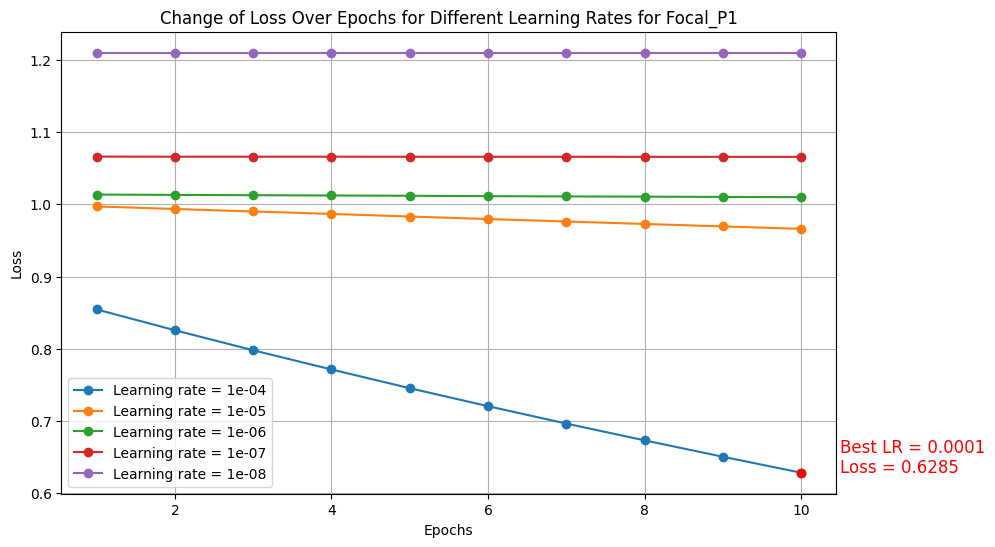

In [17]:
# Losses for each learning rate over epochs
losses_lr_1e_04 = [0.8545, 0.8257, 0.7980, 0.7714, 0.7455, 0.7206, 0.6965, 0.6733, 0.6506, 0.6285]
losses_lr_1e_05 = [0.9971, 0.9935, 0.9901, 0.9867, 0.9831, 0.9796, 0.9762, 0.9728, 0.9694, 0.9660]
losses_lr_1e_06 = [1.0135, 1.0130, 1.0126, 1.0122, 1.0118, 1.0113, 1.0109, 1.0106, 1.0102, 1.0099]
losses_lr_1e_07 = [1.0660, 1.0659, 1.0659, 1.0659, 1.0658, 1.0658, 1.0658, 1.0657, 1.0657, 1.0657]
losses_lr_1e_08 = [1.2098, 1.2098, 1.2098, 1.2098, 1.2098, 1.2098, 1.2098, 1.2098, 1.2098, 1.2098]

# Best learning rate and its corresponding loss
best_lr = 1e-04
best_loss = 0.6285353899002075

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each learning rate's loss change over epochs
plt.plot(range(1, 11), losses_lr_1e_04, label='Learning rate = 1e-04', marker='o')
plt.plot(range(1, 11), losses_lr_1e_05, label='Learning rate = 1e-05', marker='o')
plt.plot(range(1, 11), losses_lr_1e_06, label='Learning rate = 1e-06', marker='o')
plt.plot(range(1, 11), losses_lr_1e_07, label='Learning rate = 1e-07', marker='o')
plt.plot(range(1, 11), losses_lr_1e_08, label='Learning rate = 1e-08', marker='o')

# Mark the best learning rate
plt.scatter(10, best_loss, color='red', zorder=5)
plt.text(10.5, best_loss, f'Best LR = {best_lr}\nLoss = {best_loss:.4f}', color='red', fontsize=12)

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Change of Loss Over Epochs for Different Learning Rates for Focal_P1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


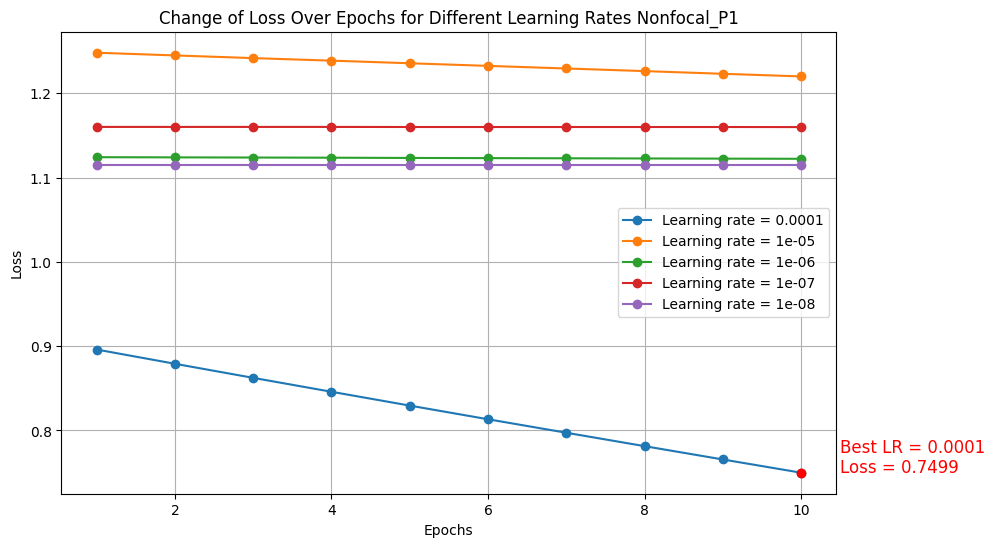

In [20]:

# Losses for each learning rate over epochs
losses_lr_1e_04 = [0.8960, 0.8791, 0.8624, 0.8459, 0.8295, 0.8133, 0.7973, 0.7814, 0.7656, 0.7499]
losses_lr_1e_05 = [1.2480, 1.2448, 1.2416, 1.2386, 1.2355, 1.2324, 1.2293, 1.2262, 1.2230, 1.2199]
losses_lr_1e_06 = [1.1241, 1.1239, 1.1237, 1.1235, 1.1232, 1.1230, 1.1228, 1.1226, 1.1224, 1.1222]
losses_lr_1e_07 = [1.1600, 1.1600, 1.1600, 1.1600, 1.1599, 1.1599, 1.1599, 1.1599, 1.1599, 1.1598]
losses_lr_1e_08 = [1.1152, 1.1152, 1.1152, 1.1152, 1.1152, 1.1152, 1.1152, 1.1152, 1.1152, 1.1152]

# Best learning rate and its corresponding loss
best_lr = 0.0001
best_loss = 0.7498897910118103

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each learning rate's loss change over epochs
plt.plot(range(1, 11), losses_lr_1e_04, label='Learning rate = 0.0001', marker='o')
plt.plot(range(1, 11), losses_lr_1e_05, label='Learning rate = 1e-05', marker='o')
plt.plot(range(1, 11), losses_lr_1e_06, label='Learning rate = 1e-06', marker='o')
plt.plot(range(1, 11), losses_lr_1e_07, label='Learning rate = 1e-07', marker='o')
plt.plot(range(1, 11), losses_lr_1e_08, label='Learning rate = 1e-08', marker='o')

# Mark the best learning rate
plt.scatter(10, best_loss, color='red', zorder=5)
plt.text(10.5, best_loss, f'Best LR = {best_lr}\nLoss = {best_loss:.4f}', color='red', fontsize=12)

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Change of Loss Over Epochs for Different Learning Rates Nonfocal_P1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


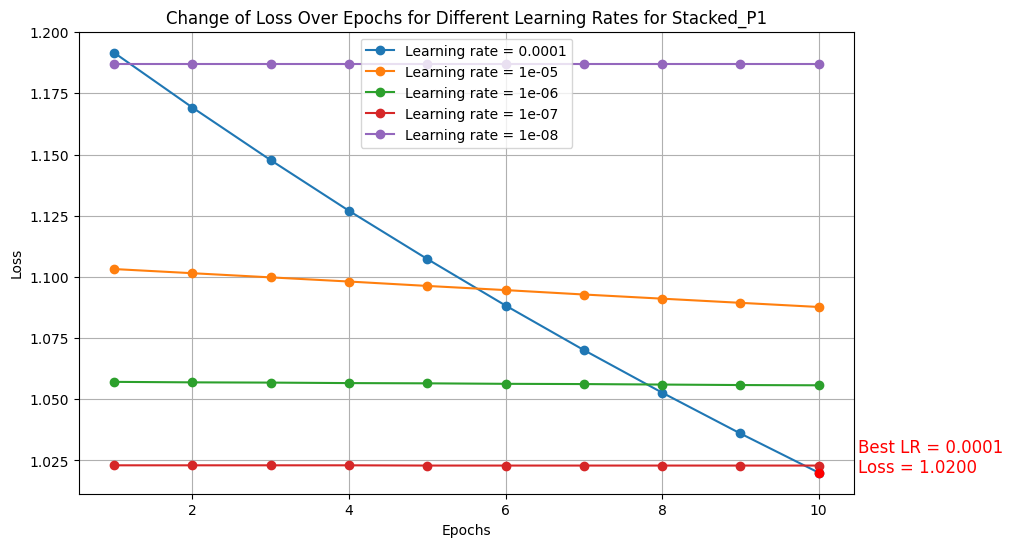

In [22]:
# Losses for each learning rate over epochs
losses_lr_1e_04 = [1.1916, 1.1692, 1.1477, 1.1270, 1.1073, 1.0883, 1.0701, 1.0527, 1.0360, 1.0200]
losses_lr_1e_05 = [1.1032, 1.1015, 1.0998, 1.0981, 1.0963, 1.0946, 1.0928, 1.0911, 1.0894, 1.0877]
losses_lr_1e_06 = [1.0571, 1.0569, 1.0568, 1.0566, 1.0565, 1.0563, 1.0562, 1.0560, 1.0558, 1.0557]
losses_lr_1e_07 = [1.0230, 1.0230, 1.0230, 1.0230, 1.0229, 1.0229, 1.0229, 1.0229, 1.0229, 1.0229]
losses_lr_1e_08 = [1.1871, 1.1871, 1.1871, 1.1871, 1.1871, 1.1871, 1.1871, 1.1871, 1.1871, 1.1871]

# Best learning rate and its corresponding loss
best_lr = 0.0001
best_loss = 1.0199722051620483

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each learning rate's loss change over epochs
plt.plot(range(1, 11), losses_lr_1e_04, label='Learning rate = 0.0001', marker='o')
plt.plot(range(1, 11), losses_lr_1e_05, label='Learning rate = 1e-05', marker='o')
plt.plot(range(1, 11), losses_lr_1e_06, label='Learning rate = 1e-06', marker='o')
plt.plot(range(1, 11), losses_lr_1e_07, label='Learning rate = 1e-07', marker='o')
plt.plot(range(1, 11), losses_lr_1e_08, label='Learning rate = 1e-08', marker='o')

# Mark the best learning rate
plt.scatter(10, best_loss, color='red', zorder=5)
plt.text(10.5, best_loss, f'Best LR = {best_lr}\nLoss = {best_loss:.4f}', color='red', fontsize=12)

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Change of Loss Over Epochs for Different Learning Rates for Stacked_P1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [19]:
torch.save(model.state_dict(), "hybrid_model_real_data.pth")
print("Model saved successfully!")

Model saved successfully!
